# ANALYSING ACTIVITY LEVELS WITH FITBIT DATASET


**Data sources:** https://www.kaggle.com/datasets/arashnic/fitbit
<br>
**License:** https://creativecommons.org/publicdomain/zero/1.0/
<br><br>
**Brief description of the dataset:** 
"This dataset generated by respondents to a distributed survey via Amazon Mechanical Turk between 03.12.2016-05.12.2016. Thirty eligible Fitbit users consented to the submission of personal tracker data, including minute-level output for physical activity, heart rate, and sleep monitoring. Individual reports can be parsed by export session ID (column A) or timestamp (column B). Variation between output represents use of different types of Fitbit trackers and individual tracking behaviors / preferences."

## Introduction
**Driving question:** Among these people, is their daily step count higher if they are more active in the morning? 
<br><br>
**Overview of the notebook:** In this notebook, we have generated numerical summaries, including the median step count, and created data visualizations using the daily_steps and hourly_steps datasets. In conclusion, while a higher step count is positively correlated with a higher daily step count, there is no evidence to suggest that 'Morning' has a greater significance in the total step count compared to other times of the day.
<br><br>
**Goal of the analysis:** Answer the driving question and compare the results between morning and different times of the day to identify any underlying relationships.
<br><br>
**Knowledge about the dataset:** There are two datasets that we are using, hourly_steps and daily_steps.  Thirty eligible Fitbit users consented to the submission of personal tracker data.
<br><br>
**Assumptions:** No significant underlying biases or confounding factors affect the analysis results.
<br><br>
**Initial prediction**: We expect a positive correlation between morning step count and daily step count due to its inclusion in the metric. However, we do not anticipate a substantial difference in the significance of morning step count compared to other parts of the day.
<br><br>
**Analysis of adherence in the data:** After examining the dataset, we noticed the presence of zero entries. To address this, we removed all zero entries since distinguishing between missing data and inactivity was not possible. This action resulted in minor changes in the correlation but did not significantly alter the overall results. We also checked for missing entries, i.e. NA values, and there wasn't any.

## Loading Datasets


Import necessary libraries for data manipulation and visualization

In [1]:
# Import libraries and modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.linear_model import LinearRegression
import squarify

# Set figure to fixed size for presentation
plt.rcParams['figure.figsize'] = [25, 7]

# Retrieve and read data
current_directory = os.getcwd()
hourly_steps = pd.read_csv(current_directory + '/Fitabase Data 4.12.16-5.12.16/hourlySteps_merged.csv')

## Data Cleaning

Changing the columns of day and hour to pandas datetime format, filter rows with zero entries

In [2]:
hourly_steps['ActivityHour'] = pd.to_datetime(hourly_steps['ActivityHour'])
last = hourly_steps.tail(1)
hourly_steps = hourly_steps[hourly_steps['StepTotal']!=0]

# Brief look at the dataset structure
last['ActivityHour'].dt.hour

22098    14
Name: ActivityHour, dtype: int64

Create new columns on dataframe by classifying rows based on time condition. hourly_steps contains hourly data from 6am to 12pm, 12pm to 6pm, and 6pm to 12am.


In [3]:
# Modify a copy of the  original dataset
daily_steps = hourly_steps.copy()

# Morning (6am to 12pm)
daily_steps['Morning Steps'] = np.where((daily_steps['ActivityHour'].dt.hour >= 6) & (daily_steps['ActivityHour'].dt.hour < 12), daily_steps['StepTotal'], 0)
# Afternoon (12pm to 6pm)
daily_steps['Afternoon Steps'] = np.where((daily_steps['ActivityHour'].dt.hour >= 12) & (daily_steps['ActivityHour'].dt.hour < 18), daily_steps['StepTotal'], 0)
# Evening (6pm to 12am)
daily_steps['Evening Steps'] = np.where((daily_steps['ActivityHour'].dt.hour >= 18) & (daily_steps['ActivityHour'].dt.hour < 24), daily_steps['StepTotal'], 0)

Detect and handle missing values in the given DataFrame 'data'. 
Employs the isna() function to identify any missing values and then checks whether the DataFrame contains any missing values. 
Assumption: missing values are in NaN (Not-a-Number) format so that they can be filtered by the isna() function.

In [4]:
# Check for missing values in the DataFrame
missing_values = daily_steps.isna().sum()

# Print the total number of missing values for each column
print("Missing values in the DataFrame:")
print(missing_values)

# Check if any missing values exist in the DataFrame
if daily_steps.isna().values.any():
    print("The DataFrame contains missing values.")
else:
    print("The DataFrame does not contain any missing values.")

Missing values in the DataFrame:
Id                 0
ActivityHour       0
StepTotal          0
Morning Steps      0
Afternoon Steps    0
Evening Steps      0
dtype: int64
The DataFrame does not contain any missing values.


In [5]:
# Group rows by date and id, summing up the step count
daily_steps = daily_steps.groupby([daily_steps['Id'], daily_steps['ActivityHour'].dt.date]).sum().reset_index()

# Changing the date format for better presentation
daily_steps['ActivityHour'] = pd.to_datetime(daily_steps['ActivityHour'])
daily_steps['Date'] = daily_steps['ActivityHour'].dt.strftime('%D')

# Rename columns for better presentation
daily_steps = daily_steps.rename(columns={'StepTotal': 'Total Steps'}, errors="raise")

# Brief look at the cleaned dataframe
daily_steps.iloc[:,daily_steps.columns != 'ActivityHour']

,Id,Total Steps,Morning Steps,Afternoon Steps,Evening Steps,Date
0,1503960366,13158,3150,4536,4788,04/12/16
1,1503960366,10735,2899,3852,3804,04/13/16
2,1503960366,10460,2058,4092,4171,04/14/16
3,1503960366,9685,662,2417,6298,04/15/16
4,1503960366,12669,4795,6104,1224,04/16/16
...,...,...,...,...,...,...
850,8877689391,10665,2505,4103,4057,05/08/16
851,8877689391,20156,4856,14026,1274,05/09/16
852,8877689391,10693,3811,4925,1957,05/10/16
853,8877689391,21391,3004,16089,2298,05/11/16


## Data Analysis

Find out the median steps for each hour as they are less susceptible to outliers.

In [6]:
#Change time format and store in new column
hourly_steps['Time'] = hourly_steps['ActivityHour'].dt.strftime('%H:%M')

#Group dataframe by time and take median steps 
hourly_time = hourly_steps.groupby('Time').median()

#Rename columns
hourly_time = hourly_time.rename(columns={'StepTotal' : 'Median Step'}, errors="raise")

Inspect the median step count for every hour and understand the distribution of step count for further analysis. Exploratory analysis.

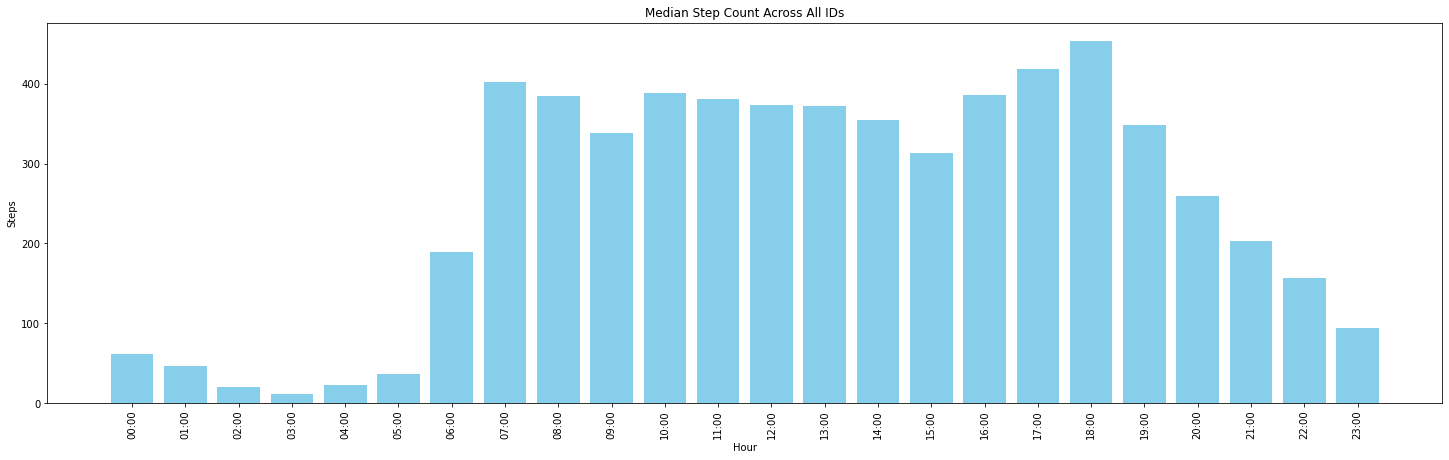

In [7]:
# Create a bar graph
fig,ax = plt.subplots(1)
ax.bar(hourly_time.index.values, hourly_time['Median Step'], color='skyblue')
ax.set(title = 'Median Step Count Across All IDs', xlabel = 'Hour', ylabel = 'Steps')

# Rotate the words in x-axis for better presentation
for label in ax.get_xticklabels():
    label.set_rotation(90)

The visualisation showcases the median step count across different hours across all IDs  offering insight into the fluctuation of step counts throughout the day. The focus should be on observing the changing patterns in median steps as the hours progress.


Categorize each day with morning step count, different activity levels defined using its quantiles.
Inspect the relationship between morning activity level and other times of the day.

In [8]:
col = 'Morning Steps'
levels     = ['Low', 'Medium', 'High']

# Finding quantiles
q0 = daily_steps[col].quantile(0.25)
q1 = daily_steps[col].quantile(0.75)

# Conditions for each level (low(below q0), medium(between q0 and q1), high(above q1))
conditions  = [daily_steps[col] <= q0, (daily_steps[col] > q0) & (daily_steps[col]<= q1), daily_steps[col]  > q1]

# new column to store the result
daily_steps['Morning Activity'] = np.select(conditions, levels, default=np.nan)

Find out relationship between median steps and morning activity level as exploratory data analysis.


In [9]:
# Group data by morning activity, take step count median
activity = daily_steps.groupby('Morning Activity').median().iloc[:, 1:5]

# Rename columns and sort rows
activity = activity.rename(columns={"Total Steps": "Median Steps","Morning Steps": "Median Morning Steps","Afternoon Steps": "Median Afternoon Steps","Evening Steps": "Median Evening Steps"}, errors="raise")
activity = activity.sort_values(by='Median Morning Steps', ascending=False)
activity

,Median Steps,Median Morning Steps,Median Afternoon Steps,Median Evening Steps
Morning Activity,,,,
High,10860.0,4944.0,3265.0,1217.5
Medium,7443.0,1977.0,2694.0,1759.0
Low,4035.0,113.5,1855.5,1441.5


Median evening steps do not have the same trend with morning steps, perhaps due to missing evening data in some days.

Calculating the correlation coefficient between the morning total step count and total step count (StepTotal), numerical summaries for clarity. Confirmatory analysis.

In [10]:
time_of_day = ['morning', 'afternoon', 'evening']
steps = ['Morning Steps', 'Afternoon Steps', 'Evening Steps']
correlations = []

for i in range(0, len(steps)):
    # Compute correlation between total steps and other parts of the day
    correlation = daily_steps['Total Steps'].corr(daily_steps[steps[i]])
    # prsent results in 3 significant figures for balance between concision and presenting differences
    correlations.append('{:.3f}'.format(correlation))
    print('Correlation coefficient between {} steps and total steps: {:.3f}'.format(time_of_day[i], correlation))

Correlation coefficient between morning steps and total steps: 0.534
Correlation coefficient between afternoon steps and total steps: 0.726
Correlation coefficient between evening steps and total steps: 0.577


Visualize correlation between daily step count and different parts of the day with scatter plots. Confirmatory analysis.

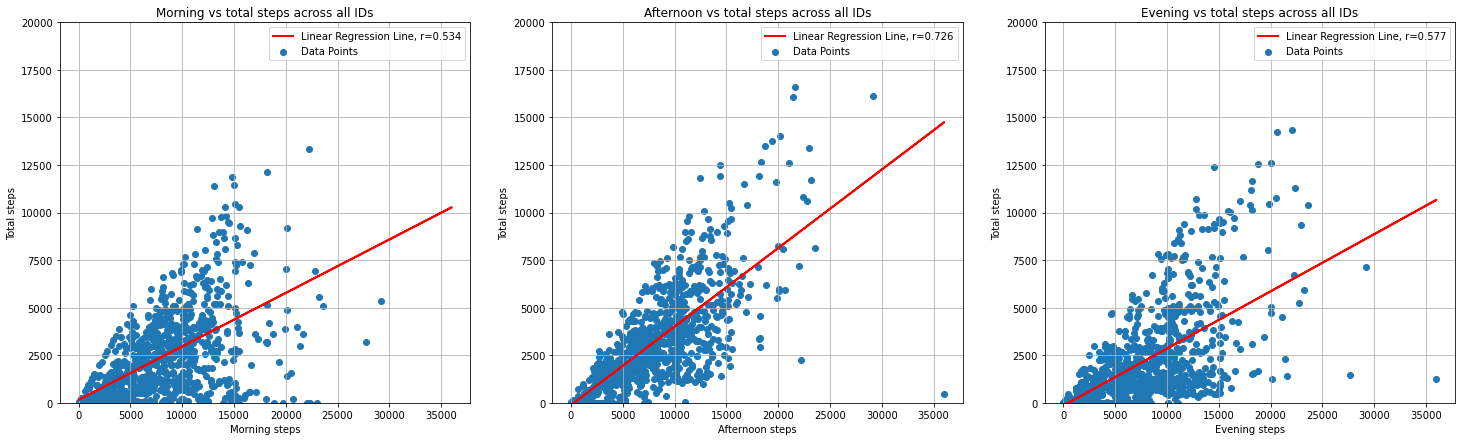

In [11]:
# 3 plots side by side for better comparison
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
xlabels = ['Morning steps', 'Afternoon steps', 'Evening steps']
ax = [ax1, ax2, ax3]

for i in range(0, len(steps)):
    ax[i].scatter(daily_steps['Total Steps'], daily_steps[steps[i]], label='Data Points')

    # Fit a linear regression model
    X = daily_steps['Total Steps'].values.reshape(-1, 1)
    y = daily_steps[steps[i]].values
    model = LinearRegression().fit(X, y)

    # Predict the values using the linear model
    y_pred = model.predict(X)

    # Plot the linear regression line
    ax[i].plot(daily_steps['Total Steps'], y_pred, color='red', linewidth=2, label='Linear Regression Line, r={}'.format(correlations[i]))
    # Set x limit for better comparison between plots
    # Outliers were not shown since they are insignificant in this context
    ax[i].set(xlabel=xlabels[i], ylabel='Total steps', title = '{} vs total steps across all IDs'.format(time_of_day[i].title()), ylim =[0,20000])
    ax[i].legend()
    ax[i].grid(True)

The scatter plots with linear regresison lines highlight the correlation between morning, afternoon and evening step counts against the total daily steps. The focus should be on discerning how different parts of the day are correlated with the overall step count. Outliers are not too significant as each data points refer to an individual day.

Visualize and explore any underlying relationship between step count for different parts of the day in a time series manner. 
Possible to observe trends that are not visible with the correlation analysis. Exploratory analysis.

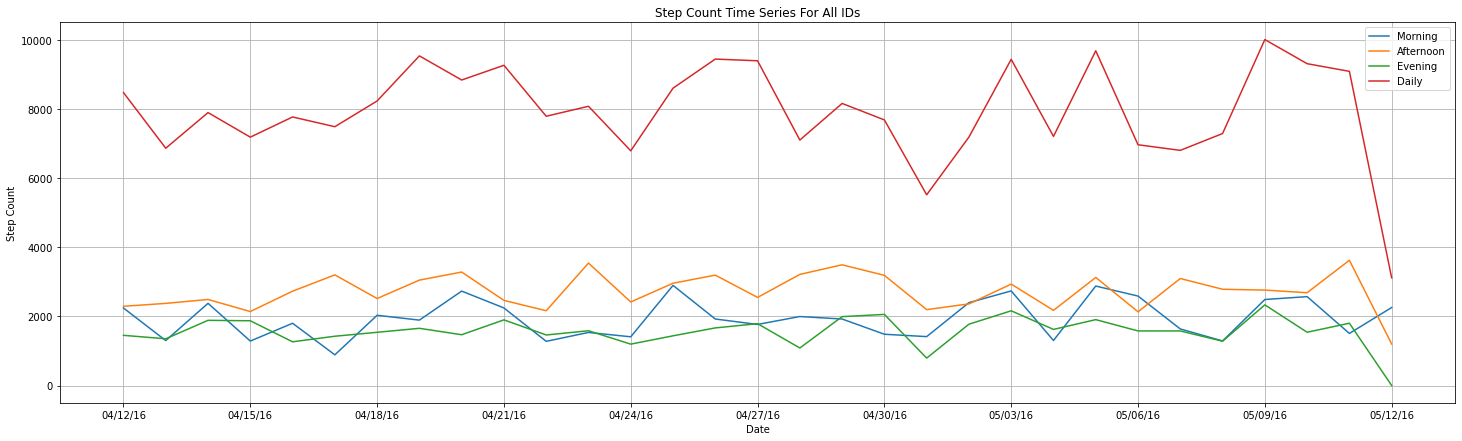

In [12]:
fig,ax = plt.subplots(1)

# Find median steps(daily, morning, afternoon, evening) for each day
daily_median = daily_steps.groupby('Date').median()

# Plot as time series, where index.values are the dates
for step in steps:
    ax.plot(daily_median.index.values, daily_median[step])

ax.plot(daily_median.index.values, daily_median['Total Steps'])

ax.set(xlabel='Date', ylabel='Step Count', title = 'Step Count Time Series For All IDs')
ax.legend(['Morning', 'Afternoon', 'Evening','Daily'])
ax.grid(True)

# Limiting the number of ticks since there are too many date in the x axis
num_ticks = 8
date_indices = range(0, len(daily_median.index.values), len(daily_median.index.values) // num_ticks)
ax.set_xticks([list(daily_median.index.values)[i] for i in date_indices])
plt.show()

Afternoon has the highest step count, but the similarity between time series are not clear. This time series plot shows the relationship between the four distinct curves and how the three curves representing the different parts of the day contribute to the overall daily step count across all IDs.


Group the dataframe by id to obtain data for each person. Exploratory analysis.

In [13]:
# Group the dataset by id(person)
daily_id = daily_steps.copy()
daily_id = daily_id.groupby('Id').sum()

Since daily data does not establish any strong correlation, we will inspect data for each person. Creates ranks for the step count of each person, each rank associate to different parts of the day.

In [14]:
# Ranking the person with total steps amongst the dataset, and assigning this rank to the id
daily_id['Total Rank'] = daily_id['Total Steps'].rank(method = 'min', ascending = False)

rank = ['Morning Rank', 'Afternoon Rank', 'Evening Rank']

# Similarly for morning, afternoon and evening steps
for i in range(0, len(rank)):
    daily_id[rank[i]] = daily_id[steps[i]].rank(method = 'min',ascending = False)

Compute the difference between the total rank and rank for other parts of the day. Exploratory analysis.

In [15]:
rank_diff = ['Morning Rank Diff', 'Afternoon Rank Diff', 'Evening Rank Diff']

# Finding the rank difference between total and (morning, afternoon evening) steps
for i in range(0, len(rank)):
    daily_id[rank_diff[i]] = abs(daily_id['Total Rank'] - daily_id[rank[i]])

# Brief overview of the result
daily_id.iloc[0:5,:]

,Total Steps,Morning Steps,Afternoon Steps,Evening Steps,Total Rank,Morning Rank,Afternoon Rank,Evening Rank,Morning Rank Diff,Afternoon Rank Diff,Evening Rank Diff
Id,,,,,,,,,,,
1503960366,374546,67627,111080,188660,3.0,13.0,11.0,2.0,10.0,8.0,1.0
1624580081,177750,75668,49548,46060,19.0,12.0,25.0,18.0,7.0,6.0,1.0
1644430081,217927,29225,66972,116599,16.0,25.0,21.0,5.0,9.0,5.0,11.0
1844505072,79942,18750,31503,25830,28.0,27.0,28.0,24.0,1.0,0.0,4.0
1927972279,28400,11459,10752,5997,32.0,30.0,32.0,32.0,2.0,0.0,0.0


The focus should be on observing the spread of the rank differences between the total daily rank and ranks associated with different parts of the day across all IDs. Rank diff computes the absolute difference between said rank and the total rank.
Descending order: i.e. person with rank 1.0 has the most step count. Conclusion: Difficult to tell the similarities from table, some rank differences are significant.

Boxplots to visualize the differences. Exploratory analysis.

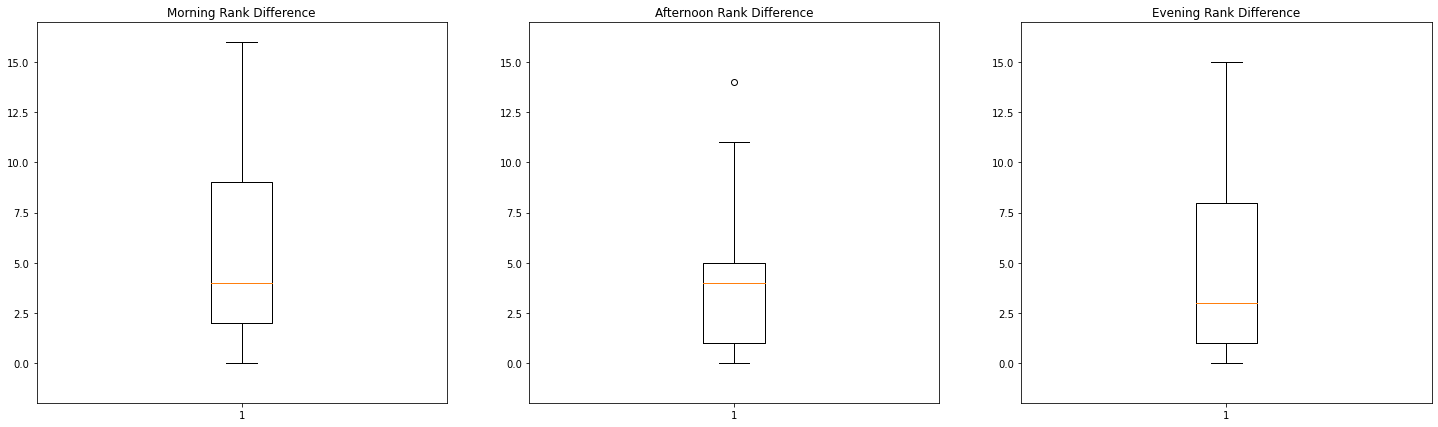

In [16]:
# Three plots side-by-side for better comparison
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax = [ax1, ax2, ax3]

# Boxplots on the difference in rank for each person (total vs (morning, afternoon, evening))
for i in range(0, len(ax)):
    ax[i].boxplot(daily_id[rank_diff[i]])
    # Set ylimit for better comparison
    ax[i].set(ylim = (-2,17), title = '{} rank difference'.format(time_of_day[i]).title())

Conclusion: The median are very similar, the IQR(length of the boxes) and range(length between the two horizontal lines) are much smaller for the aftenoon. IQR and range are similar for morning and evening, result inline with the correlation analysis.

## Final Commentary
While a higher morning step count is associated with a higher daily step count, there is no substantial evidence to suggest that this impact is greater than that of afternoon or evening steps. 

Additionally, we assumed a bias-free dataset for this analysis, it's important to note that such an assumption may not hold true, given that all respondents consented to share their data.